In [ ]:
# Install libraries if needed (Uncomment if needed)
# !pip install tensorflow opencv-python seaborn

# Imports
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set your data path here after mounting
data_dir = '/content/drive/MyDrive/Colab Notebooks/train'  # <-- Adjust this to your actual path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001
FRAMES_PER_VIDEO = 10  # Number of frames to extract per video


In [ ]:
# Extract frames from videos
def extract_frames(video_path, num_frames=FRAMES_PER_VIDEO):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, IMG_SIZE)
            frames.append(frame)

    cap.release()
    return frames

# Load dataset
def load_dataset(data_dir):
    images = []
    labels = []

    violence_dir = os.path.join(data_dir, 'Fight')
    non_violence_dir = os.path.join(data_dir, 'NonFight')

    for label_dir, label in [(violence_dir, 1), (non_violence_dir, 0)]:
        for video_file in os.listdir(label_dir):
            if video_file.endswith(('.avi', '.mp4', '.mov')):
                video_path = os.path.join(label_dir, video_file)
                try:
                    frames = extract_frames(video_path)
                    images.extend(frames)
                    labels.extend([label] * len(frames))
                except Exception as e:
                    print(f"Error processing {video_file}: {e}")

    return np.array(images), np.array(labels)


In [ ]:
print("Loading dataset...")
X, y = load_dataset(data_dir)

if len(X) == 0:
    raise ValueError("No valid video frames were loaded. Please check your video files and paths.")

# Normalize pixel values
X = X.astype('float32') / 255.0

# One-hot encode labels
y = to_categorical(y, num_classes=2)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Loading dataset...
Training set: 11200 samples
Validation set: 2400 samples
Test set: 2400 samples


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)


In [ ]:
def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    return model

model = create_model((IMG_SIZE[0], IMG_SIZE[1], 3))
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,110,466 (19.49 MB)

 Trainable params: 5,109,506 (19.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5619 - loss: 2.0672
Epoch 1: val_accuracy improved from -inf to 0.56125, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.5620 - loss: 2.0643 - val_accuracy: 0.5612 - val_loss: 0.7269 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6677 - loss: 0.6093
Epoch 2: val_accuracy improved from 0.56125 to 0.69417, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - accuracy: 0.6677 - loss: 0.6093 - val_accuracy: 0.6942 - val_loss: 0.5477 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6979 - loss: 0.5812
Epoch 3: val_accuracy did not improve from 0.69417
350/350 ━━━━━━━━━━━━━━━━━━━━ 692s 2s/step - accuracy: 0.6979 - loss: 0.5812 - val_accuracy: 0.6442 - val_loss: 0.8895 - learning_rate: 0.0010
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6948 - loss: 0.5809
Epoch 4: val_accuracy did not improve from 0.69417
350/350 ━━━━━━━━━━━━━━━━━━━━ 673s 2s/step - accuracy: 0.6948 - loss: 0.5809 - val_accuracy: 0.6587 - val_loss: 0.7298 - learning_rate: 0.0010
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7053 - loss: 0.5610
Epoch 5: val_accuracy improved from 0.69417 to 0.69917, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.7053 - loss: 0.5610 - val_accuracy: 0.6992 - val_loss: 0.5855 - learning_rate: 0.0010
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7225 - loss: 0.5427
Epoch 6: val_accuracy did not improve from 0.69917
350/350 ━━━━━━━━━━━━━━━━━━━━ 676s 2s/step - accuracy: 0.7225 - loss: 0.5427 - val_accuracy: 0.5979 - val_loss: 0.7543 - learning_rate: 0.0010
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7329 - loss: 0.5210
Epoch 7: val_accuracy did not improve from 0.69917
350/350 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.7329 - loss: 0.5210 - val_accuracy: 0.5700 - val_loss: 0.7574 - learning_rate: 0.0010
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7667 - loss: 0.4577
Epoch 8: val_accuracy improved from 0.69917 to 0.78125, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 686s 2s/step - accuracy: 0.7667 - loss: 0.4577 - val_accuracy: 0.7812 - val_loss: 0.4545 - learning_rate: 2.0000e-04
Epoch 9/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7866 - loss: 0.4251
Epoch 9: val_accuracy improved from 0.78125 to 0.81125, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.7867 - loss: 0.4250 - val_accuracy: 0.8112 - val_loss: 0.3800 - learning_rate: 2.0000e-04
Epoch 10/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8074 - loss: 0.3870
Epoch 10: val_accuracy improved from 0.81125 to 0.82792, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 670s 2s/step - accuracy: 0.8074 - loss: 0.3870 - val_accuracy: 0.8279 - val_loss: 0.3760 - learning_rate: 2.0000e-04
Epoch 11/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8214 - loss: 0.3624
Epoch 11: val_accuracy did not improve from 0.82792
350/350 ━━━━━━━━━━━━━━━━━━━━ 689s 2s/step - accuracy: 0.8214 - loss: 0.3624 - val_accuracy: 0.8163 - val_loss: 0.3944 - learning_rate: 2.0000e-04
Epoch 12/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8266 - loss: 0.3493
Epoch 12: val_accuracy did not improve from 0.82792
350/350 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.8266 - loss: 0.3493 - val_accuracy: 0.8221 - val_loss: 0.3952 - learning_rate: 2.0000e-04
Epoch 13/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8300 - loss: 0.3492
Epoch 13: val_accuracy improved from 0.82792 to 0.84042, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.8300 - loss: 0.3492 - val_accuracy: 0.8404 - val_loss: 0.3275 - learning_rate: 2.0000e-04
Epoch 14/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8434 - loss: 0.3252
Epoch 14: val_accuracy improved from 0.84042 to 0.84750, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 697s 2s/step - accuracy: 0.8434 - loss: 0.3252 - val_accuracy: 0.8475 - val_loss: 0.3118 - learning_rate: 2.0000e-04
Epoch 15/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8470 - loss: 0.3219
Epoch 15: val_accuracy did not improve from 0.84750
350/350 ━━━━━━━━━━━━━━━━━━━━ 667s 2s/step - accuracy: 0.8470 - loss: 0.3219 - val_accuracy: 0.8467 - val_loss: 0.3639 - learning_rate: 2.0000e-04
Epoch 16/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8584 - loss: 0.2961
Epoch 16: val_accuracy did not improve from 0.84750
350/350 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - accuracy: 0.8584 - loss: 0.2961 - val_accuracy: 0.8413 - val_loss: 0.3253 - learning_rate: 2.0000e-04
Epoch 17/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8563 - loss: 0.2990
Epoch 17: val_accuracy did not improve from 0.84750
350/350 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.8563 - loss: 0.2989 - val_accuracy: 0.8158 - val_loss: 0.4849 - learning_rate: 2.0000e-04
Ep

350/350 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.8749 - loss: 0.2776 - val_accuracy: 0.8646 - val_loss: 0.2801 - learning_rate: 2.0000e-04
Epoch 19/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8734 - loss: 0.2715
Epoch 19: val_accuracy improved from 0.86458 to 0.90542, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 674s 2s/step - accuracy: 0.8734 - loss: 0.2715 - val_accuracy: 0.9054 - val_loss: 0.2147 - learning_rate: 2.0000e-04
Epoch 20/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8762 - loss: 0.2562
Epoch 20: val_accuracy did not improve from 0.90542
350/350 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.8762 - loss: 0.2562 - val_accuracy: 0.8175 - val_loss: 0.5305 - learning_rate: 2.0000e-04
Epoch 21/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8895 - loss: 0.2477
Epoch 21: val_accuracy did not improve from 0.90542
350/350 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.8894 - loss: 0.2477 - val_accuracy: 0.8700 - val_loss: 0.3146 - learning_rate: 2.0000e-04
Epoch 22/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8899 - loss: 0.2425
Epoch 22: val_accuracy did not improve from 0.90542
350/350 ━━━━━━━━━━━━━━━━━━━━ 721s 2s/step - accuracy: 0.8899 - loss: 0.2425 - val_accuracy: 0.8612 - val_loss: 0.3304 - learning_rate: 2.0000e-04
Ep

350/350 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.9135 - loss: 0.1892 - val_accuracy: 0.9142 - val_loss: 0.2143 - learning_rate: 4.0000e-05
Epoch 28/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9258 - loss: 0.1720
Epoch 28: val_accuracy did not improve from 0.91417
350/350 ━━━━━━━━━━━━━━━━━━━━ 667s 2s/step - accuracy: 0.9258 - loss: 0.1720 - val_accuracy: 0.9096 - val_loss: 0.2148 - learning_rate: 4.0000e-05
Epoch 29/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9151 - loss: 0.1845
Epoch 29: val_accuracy did not improve from 0.91417
350/350 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.9151 - loss: 0.1845 - val_accuracy: 0.9046 - val_loss: 0.2326 - learning_rate: 4.0000e-05
Epoch 30/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9235 - loss: 0.1763
Epoch 30: val_accuracy improved from 0.91417 to 0.91875, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.9235 - loss: 0.1763 - val_accuracy: 0.9187 - val_loss: 0.1885 - learning_rate: 4.0000e-05


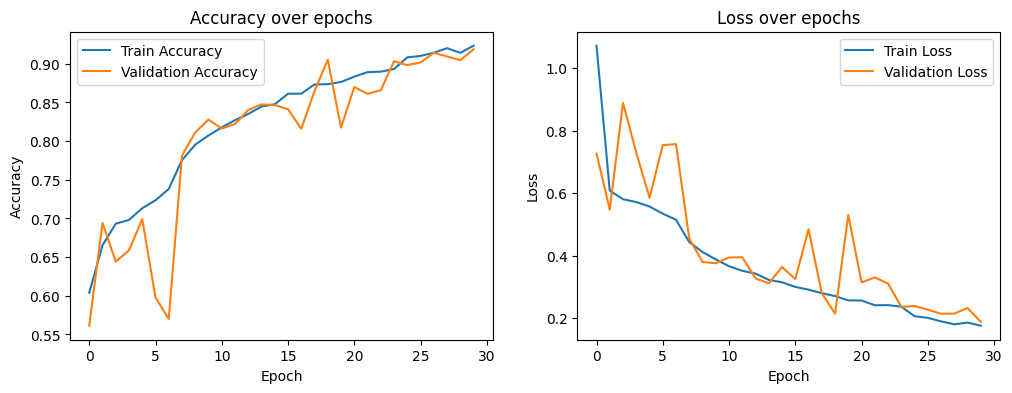

In [14]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

plot_history(history)


In [15]:
# Load best model
best_model = load_model('best_model.h5')

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc*100:.2f}%")

# Save final model
best_model.save('violence_detection_model.h5')
print("Model saved as 'violence_detection_model.h5'")


75/75 - 28s - 371ms/step - accuracy: 0.9183 - loss: 0.1877



Test accuracy: 91.83%
Model saved as 'violence_detection_model.h5'


75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 377ms/step

Classification Report:
              precision    recall  f1-score   support

Non-Violence       0.94      0.89      0.92      1200
    Violence       0.90      0.94      0.92      1200

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



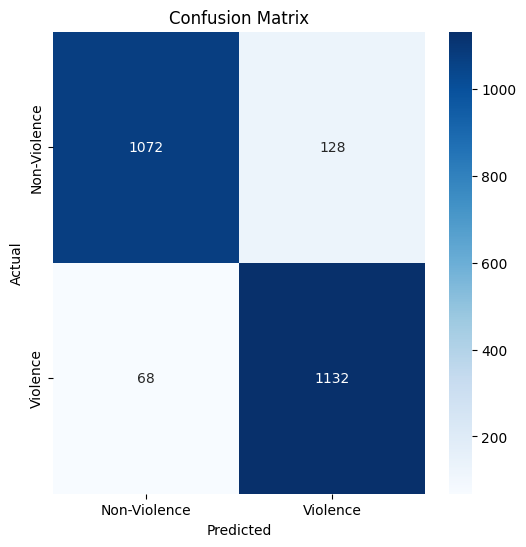

In [16]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Non-Violence', 'Violence']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Violence', 'Violence'],
            yticklabels=['Non-Violence', 'Violence'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
